# Appendix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Przygotowanie danych
Ponownie operuje na 

In [2]:
df = pd.read_csv('./train.csv')

In [4]:
df.groupby("Sex").count()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Sex,,,,,,,,,,,
female,314,314,314,314,261,314,314,314,314,97,312
male,577,577,577,577,453,577,577,577,577,107,577


In [3]:
df = pd.read_csv('./train.csv', index_col='PassengerId')
df.reset_index(inplace=True)

df['Sex'] = (df['Sex'] == 'female').astype(int)

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

In [58]:
continous_columns = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_columns = [ 'Pclass',  'Sex']

model_columns = categorical_columns + continous_columns
    
X_train, y_train = df_train[model_columns], df_train['Survived']
X_test, y_test = df_test[model_columns], df_test['Survived']

## Trening 4 modeli:
* Lightgbm
* Sieć neuronowa
* Regresja Logistyczna
* Las losowy

In [10]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
preprocess = make_pipeline(imputer)
lgbm = LGBMClassifier(max_depth=4)

model_lgbm = make_pipeline(preprocess, lgbm)
model_lgbm.fit(X_train,y_train, lgbmclassifier__categorical_feature=[model_columns.index(col) for col in categorical_columns])

/home/azapala/anaconda3/envs/main/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('lgbmclassifier', LGBMClassifier(max_depth=4))])

In [11]:
net = MLPClassifier(hidden_layer_sizes=(30,10), max_iter=1000)
model_net = make_pipeline(preprocess, net)
model_net.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(30, 10), max_iter=1000))])

In [12]:
lr = LogisticRegression()

num_preprocess = make_pipeline(imputer,  StandardScaler())
cat_preprocess = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

preprocessor_one_hot = ColumnTransformer([
        ('num', num_preprocess, continous_columns),
        ('cat', cat_preprocess, categorical_columns)])

model_lr = make_pipeline(preprocessor_one_hot, lr)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 

In [88]:
rf = RandomForestClassifier(n_estimators=20, max_depth=4)
model_rf = make_pipeline(preprocess, rf)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=20))])

In [89]:
def evaluate(model, model_name):
    train_preds = model.predict_proba(X_train)[:,1]
    test_preds = model.predict_proba(X_test)[:,1]

    print(f"Roc auc train {model_name}:", roc_auc_score(y_train, train_preds))
    print(f"Roc auc test {model_name}:", roc_auc_score(y_test, test_preds))

In [90]:
evaluate(model_lgbm, 'Lightgbm')
evaluate(model_net, 'siec neuronowa')
evaluate(model_lr, 'regresja logistyczna')
evaluate(model_rf, 'las losowy')

Roc auc train Lightgbm: 0.9522220932931075
Roc auc test Lightgbm: 0.9042119565217391
Roc auc train siec neuronowa: 0.8649670125650633
Roc auc test siec neuronowa: 0.875271739130435
Roc auc train regresja logistyczna: 0.8399363458541922
Roc auc test regresja logistyczna: 0.8599184782608696
Roc auc train las losowy: 0.87906126711534
Roc auc test las losowy: 0.887975543478261


In [91]:
def calculate_fairness_metrics(model, X_train, y_train):
    train_preds = model.predict_proba(X_train)[:,1]
    threshold = 0.5
    train_class = (train_preds > threshold)
    tn, fp, fn, tp = confusion_matrix(y_train, train_class).ravel()
    statistical_parity_ratio = (tp+fp)/(tp+fp+tn+fn)
    equal_opportunity_ratio = (tp)/(tp+fn)
    predictive_equality_ratio = fp/(fp+tn) 
    accuracy_equality_ratio = (tp+tn) / (tp+fp+tn+fn)
    return statistical_parity_ratio, equal_opportunity_ratio, predictive_equality_ratio, accuracy_equality_ratio

In [92]:
from collections import defaultdict
res = defaultdict(list)
for model, model_name in zip([model_lgbm, model_lr, model_net, model_rf], ['lgbm', 'logistic regression', 'net', 'random forest']):
    for sex in [0,1]:
        statistical_parity_ratio, equal_opportunity_ratio, predictive_equality_ratio, accuracy_equality_ratio = calculate_fairness_metrics(model, X_train[X_train.Sex == sex], y_train[X_train.Sex == sex])
        res['statistical_parity_ratio'].append(statistical_parity_ratio)
        res['equal_opportunity_ratio'].append(equal_opportunity_ratio)
        res['predictive_equality_ratio'].append(predictive_equality_ratio)
        res['accuracy_equality_ratio'].append(accuracy_equality_ratio)
        res['sex'].append('female' if sex else 'male')
        res['model'].append(model_name)

In [93]:
df_res = pd.DataFrame(res)

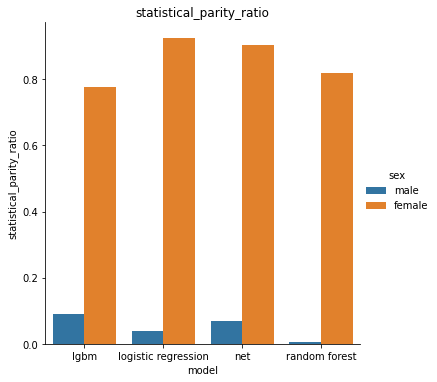

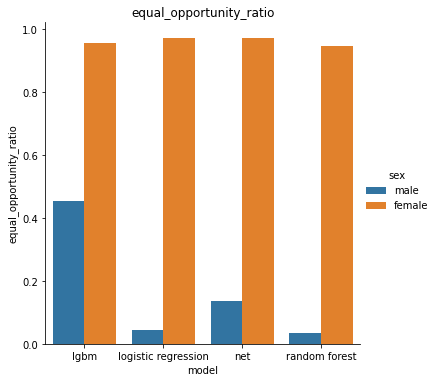

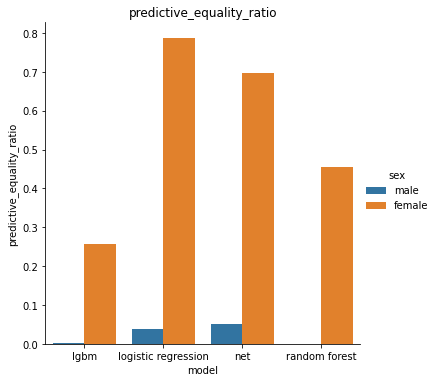

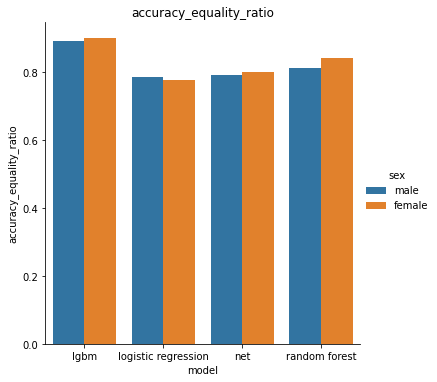

In [94]:
for metric in ['statistical_parity_ratio', 'equal_opportunity_ratio', 'predictive_equality_ratio', 'accuracy_equality_ratio']:
    sn.catplot(x='model', y=metric, hue='sex', data=df_res, kind='bar')
    plt.title(metric)
    plt.savefig(f"{metric}.png")